In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig
!pip install graphlime

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

#. GraphLime
from graphlime import GraphLIME

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
Explainability_name = 'GraphLime'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [10]:
dataset2 = balanced_train_test_split(dataset)
dataset_GraphLime = dataset2[0]
print(dataset_GraphLime)
print(len(dataset_GraphLime))
print(len(dataset_GraphLime.x[dataset_GraphLime.train_mask]))
print(len(dataset_GraphLime.x[dataset_GraphLime.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [11]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [12]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [13]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [14]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [15]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # --- add require_grad ---
        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        # --- My: record edge_weight ---
        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        # Otherwise, run both functions in separation.
        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            # For `GNNExplainer`, we require a separate message and aggregate
            # procedure since this allows us to inject the `edge_mask` into the
            # message passing computation scheme.
            if self._explain:
                edge_mask = self.__edge_mask__
                # Some ops add self-loops to `edge_index`. We need to do the
                # same for `edge_mask` (but do not train those).
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [16]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_node, dim_hidden)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))

        out_readout = self.readout(post_conv2, batch)

        out = self.ffn(out_readout)

        return out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(1433, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


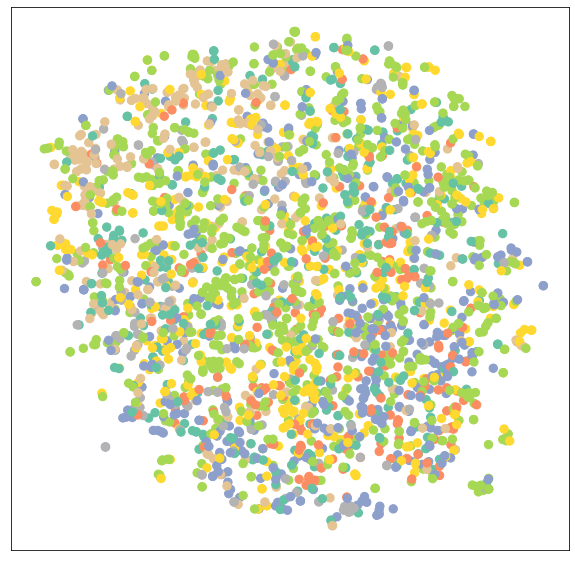

In [17]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_GraphLime.x, dataset_GraphLime.edge_index)
visualize(out, color=data.y)


In [18]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [20]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [21]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [22]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out = GCN_Model(dataset_GraphLime.x, dataset_GraphLime.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_GraphLime.train_mask], dataset_GraphLime.y[dataset_GraphLime.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [23]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [24]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, GraphLime Model Loss: 1.9302
Epoch: 002, GraphLime Model Loss: 1.9173
Epoch: 003, GraphLime Model Loss: 1.9022
Epoch: 004, GraphLime Model Loss: 1.8838
Epoch: 005, GraphLime Model Loss: 1.8632
Epoch: 006, GraphLime Model Loss: 1.8413
Epoch: 007, GraphLime Model Loss: 1.8195
Epoch: 008, GraphLime Model Loss: 1.7991
Epoch: 009, GraphLime Model Loss: 1.7814
Epoch: 010, GraphLime Model Loss: 1.7671
Epoch: 011, GraphLime Model Loss: 1.7554
Epoch: 012, GraphLime Model Loss: 1.7441
Epoch: 013, GraphLime Model Loss: 1.7307
Epoch: 014, GraphLime Model Loss: 1.7145
Epoch: 015, GraphLime Model Loss: 1.6959
Epoch: 016, GraphLime Model Loss: 1.6759
Epoch: 017, GraphLime Model Loss: 1.6554
Epoch: 018, GraphLime Model Loss: 1.6353
Epoch: 019, GraphLime Model Loss: 1.6154
Epoch: 020, GraphLime Model Loss: 1.5953
Epoch: 021, GraphLime Model Loss: 1.5741
Epoch: 022, GraphLime Model Loss: 1.5516
Epoch: 023, GraphLime Model Loss: 1.5280
Epoch: 024, GraphLime Model Loss: 1.5037
Epoch: 025, Grap

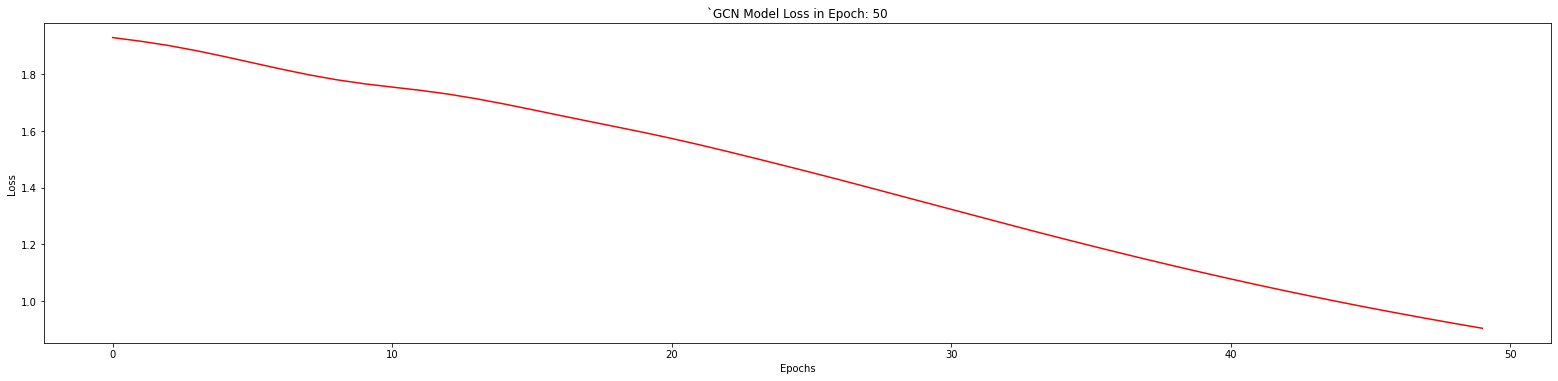

Epoch: 051, GraphLime Model Loss: 0.8876
Epoch: 052, GraphLime Model Loss: 0.8716
Epoch: 053, GraphLime Model Loss: 0.8560
Epoch: 054, GraphLime Model Loss: 0.8410
Epoch: 055, GraphLime Model Loss: 0.8264
Epoch: 056, GraphLime Model Loss: 0.8123
Epoch: 057, GraphLime Model Loss: 0.7986
Epoch: 058, GraphLime Model Loss: 0.7853
Epoch: 059, GraphLime Model Loss: 0.7725
Epoch: 060, GraphLime Model Loss: 0.7602
Epoch: 061, GraphLime Model Loss: 0.7483
Epoch: 062, GraphLime Model Loss: 0.7367
Epoch: 063, GraphLime Model Loss: 0.7255
Epoch: 064, GraphLime Model Loss: 0.7147
Epoch: 065, GraphLime Model Loss: 0.7043
Epoch: 066, GraphLime Model Loss: 0.6942
Epoch: 067, GraphLime Model Loss: 0.6844
Epoch: 068, GraphLime Model Loss: 0.6750
Epoch: 069, GraphLime Model Loss: 0.6658
Epoch: 070, GraphLime Model Loss: 0.6570
Epoch: 071, GraphLime Model Loss: 0.6485
Epoch: 072, GraphLime Model Loss: 0.6403
Epoch: 073, GraphLime Model Loss: 0.6324
Epoch: 074, GraphLime Model Loss: 0.6247
Epoch: 075, Grap

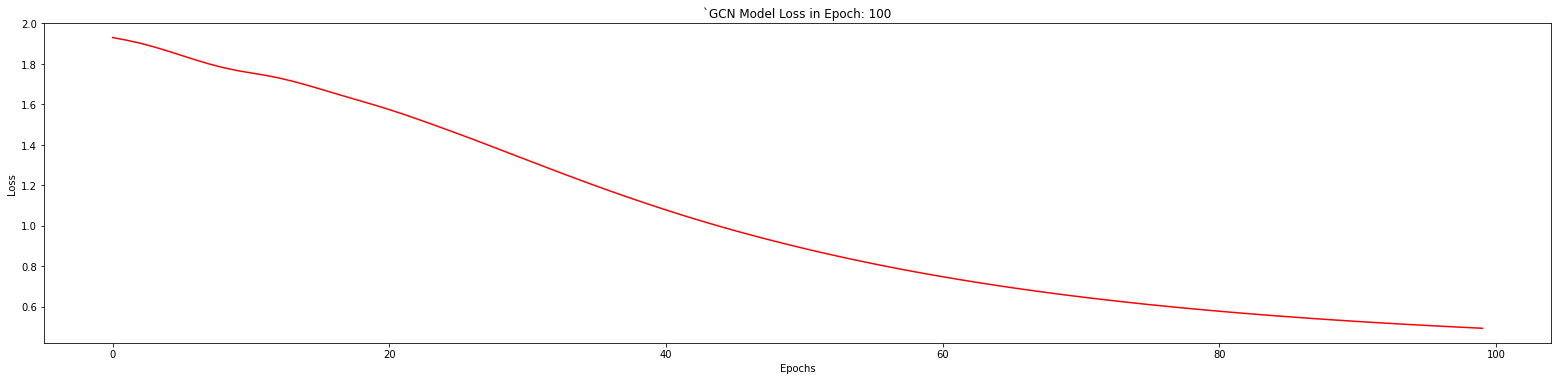

Epoch: 101, GraphLime Model Loss: 0.4905
Epoch: 102, GraphLime Model Loss: 0.4874
Epoch: 103, GraphLime Model Loss: 0.4844
Epoch: 104, GraphLime Model Loss: 0.4814
Epoch: 105, GraphLime Model Loss: 0.4785
Epoch: 106, GraphLime Model Loss: 0.4757
Epoch: 107, GraphLime Model Loss: 0.4729
Epoch: 108, GraphLime Model Loss: 0.4702
Epoch: 109, GraphLime Model Loss: 0.4676
Epoch: 110, GraphLime Model Loss: 0.4650
Epoch: 111, GraphLime Model Loss: 0.4625
Epoch: 112, GraphLime Model Loss: 0.4601
Epoch: 113, GraphLime Model Loss: 0.4577
Epoch: 114, GraphLime Model Loss: 0.4553
Epoch: 115, GraphLime Model Loss: 0.4530
Epoch: 116, GraphLime Model Loss: 0.4507
Epoch: 117, GraphLime Model Loss: 0.4485
Epoch: 118, GraphLime Model Loss: 0.4463
Epoch: 119, GraphLime Model Loss: 0.4442
Epoch: 120, GraphLime Model Loss: 0.4421
Epoch: 121, GraphLime Model Loss: 0.4400
Epoch: 122, GraphLime Model Loss: 0.4379
Epoch: 123, GraphLime Model Loss: 0.4359
Epoch: 124, GraphLime Model Loss: 0.4339
Epoch: 125, Grap

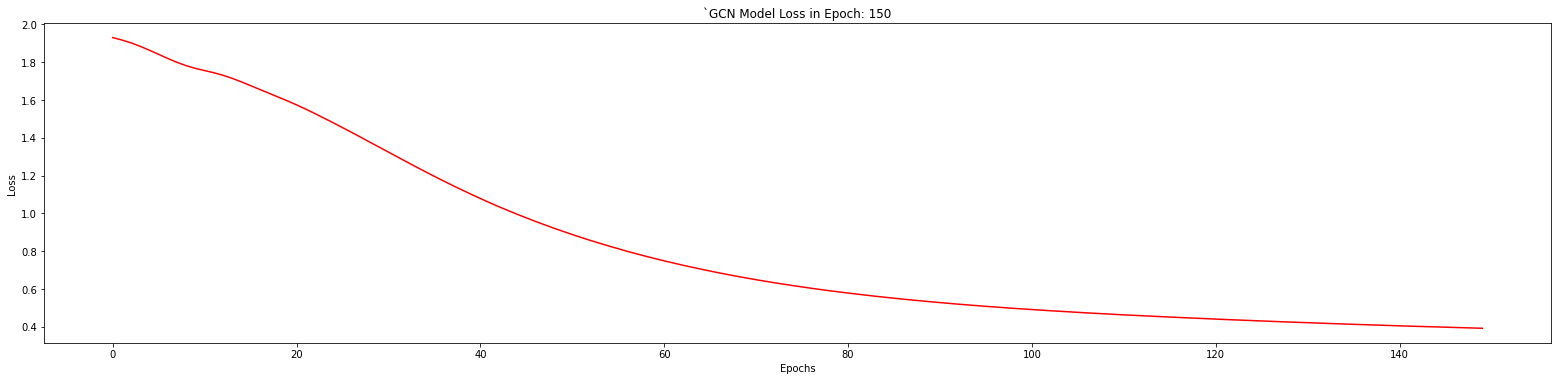

Epoch: 151, GraphLime Model Loss: 0.3902
Epoch: 152, GraphLime Model Loss: 0.3889
Epoch: 153, GraphLime Model Loss: 0.3876
Epoch: 154, GraphLime Model Loss: 0.3863
Epoch: 155, GraphLime Model Loss: 0.3851
Epoch: 156, GraphLime Model Loss: 0.3839
Epoch: 157, GraphLime Model Loss: 0.3826
Epoch: 158, GraphLime Model Loss: 0.3813
Epoch: 159, GraphLime Model Loss: 0.3801
Epoch: 160, GraphLime Model Loss: 0.3790
Epoch: 161, GraphLime Model Loss: 0.3779
Epoch: 162, GraphLime Model Loss: 0.3768
Epoch: 163, GraphLime Model Loss: 0.3756
Epoch: 164, GraphLime Model Loss: 0.3744
Epoch: 165, GraphLime Model Loss: 0.3733
Epoch: 166, GraphLime Model Loss: 0.3722
Epoch: 167, GraphLime Model Loss: 0.3711
Epoch: 168, GraphLime Model Loss: 0.3701
Epoch: 169, GraphLime Model Loss: 0.3691
Epoch: 170, GraphLime Model Loss: 0.3681
Epoch: 171, GraphLime Model Loss: 0.3671
Epoch: 172, GraphLime Model Loss: 0.3661
Epoch: 173, GraphLime Model Loss: 0.3651
Epoch: 174, GraphLime Model Loss: 0.3641
Epoch: 175, Grap

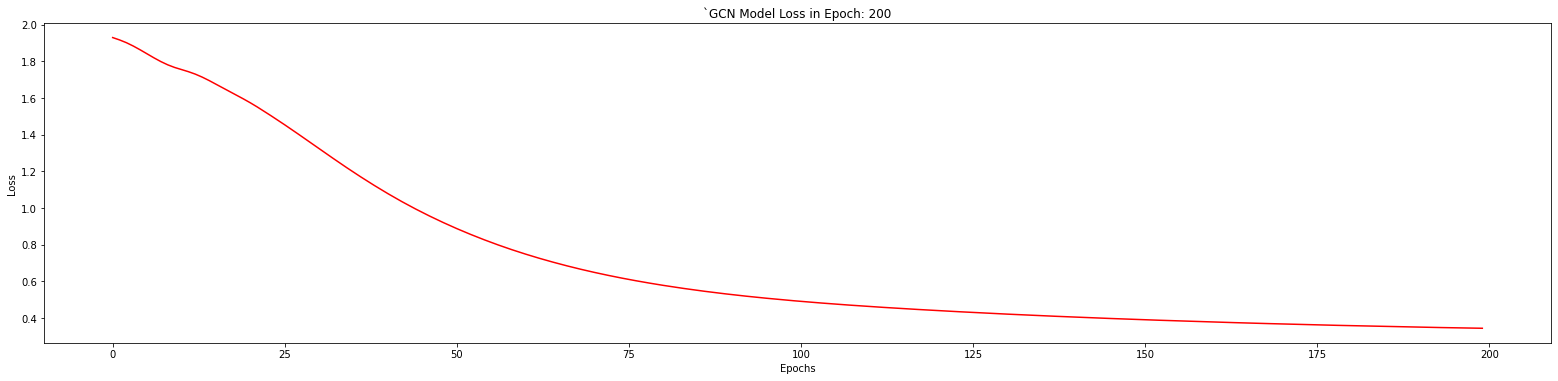

In [25]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [26]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_GraphLime.x, dataset_GraphLime.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_GraphLime.test_mask] == dataset_GraphLime.y[dataset_GraphLime.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_GraphLime.test_mask.sum())
  return GCN_Model_test_acc

In [27]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8776


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


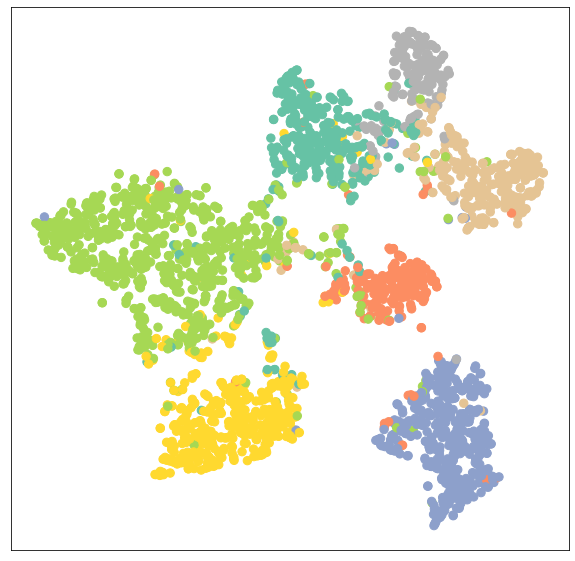

In [28]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_GraphLime.x, dataset_GraphLime.edge_index)
visualize(GCN_Model_test_out, color = dataset_GraphLime.y)

# **Index List of each Category**

In [29]:
Train_Nodes_Index_List = []
for i in range(len(dataset_GraphLime.x)):
  if dataset_GraphLime.train_mask[i]:
    Train_Nodes_Index_List.append(i)

Test_Nodes_Index_List = []
for i in range(len(dataset_GraphLime.x)):
  if dataset_GraphLime.test_mask[i]:
    Test_Nodes_Index_List.append(i)

In [30]:
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

[0, 1, 3, 6, 7, 8, 10, 13, 16, 17, 19, 21, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 54, 56, 57, 59, 61, 63, 65, 68, 69, 71, 72, 75, 76, 77, 78, 80, 82, 83, 84, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 121, 122, 124, 126, 128, 129, 130, 131, 133, 135, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 150, 153, 154, 155, 156, 157, 161, 165, 166, 168, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 216, 217, 218, 219, 220, 222, 223, 224, 226, 227, 228, 229, 231, 234, 235, 236, 237, 238, 239, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 260, 262, 264, 265, 268, 269, 270, 272, 275, 276, 277, 278, 279, 280, 282, 286, 287, 290, 291, 292, 293, 294, 295, 296, 298, 299, 302, 304, 305, 306, 311, 312, 313,

In [31]:
print(len(dataset2.data))
print(len(dataset_GraphLime.x))
print(dataset_GraphLime.keys)
print('whole dataset: ', len(dataset_GraphLime.train_mask))
print('training dataset: ', len(dataset_GraphLime.x[dataset_GraphLime.train_mask]))
print('test dataset: ', len(dataset_GraphLime.x[dataset_GraphLime.test_mask]))


6
2708
['x', 'val_mask', 'y', 'test_mask', 'edge_index', 'train_mask']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [32]:
print(len(Train_Nodes_Index_List))
print(len(Test_Nodes_Index_List))
print()
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

1891
817

[0, 1, 3, 6, 7, 8, 10, 13, 16, 17, 19, 21, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 54, 56, 57, 59, 61, 63, 65, 68, 69, 71, 72, 75, 76, 77, 78, 80, 82, 83, 84, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 121, 122, 124, 126, 128, 129, 130, 131, 133, 135, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 150, 153, 154, 155, 156, 157, 161, 165, 166, 168, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 216, 217, 218, 219, 220, 222, 223, 224, 226, 227, 228, 229, 231, 234, 235, 236, 237, 238, 239, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 260, 262, 264, 265, 268, 269, 270, 272, 275, 276, 277, 278, 279, 280, 282, 286, 287, 290, 291, 292, 293, 294, 295, 296, 298, 299, 302, 304, 305, 306, 311,

In [33]:
print(Train_Nodes_Index_List)
print(len(Train_Nodes_Index_List))

print(Test_Nodes_Index_List)
print(len(Test_Nodes_Index_List))

#print(len(dataset_PGExplainer.x[0]))

[0, 1, 3, 6, 7, 8, 10, 13, 16, 17, 19, 21, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 54, 56, 57, 59, 61, 63, 65, 68, 69, 71, 72, 75, 76, 77, 78, 80, 82, 83, 84, 86, 87, 88, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118, 121, 122, 124, 126, 128, 129, 130, 131, 133, 135, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 150, 153, 154, 155, 156, 157, 161, 165, 166, 168, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 216, 217, 218, 219, 220, 222, 223, 224, 226, 227, 228, 229, 231, 234, 235, 236, 237, 238, 239, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 260, 262, 264, 265, 268, 269, 270, 272, 275, 276, 277, 278, 279, 280, 282, 286, 287, 290, 291, 292, 293, 294, 295, 296, 298, 299, 302, 304, 305, 306, 311, 312, 313,

# **Features of Each Category**

In [34]:
training_nodes_fetures = dataset_GraphLime.x[Train_Nodes_Index_List]
test_nodes_features = dataset_GraphLime.x[Test_Nodes_Index_List]

print(len(training_nodes_fetures))
print(len(test_nodes_features))

#print(training_nodes)

training_nodes = training_nodes_fetures.detach().cpu().numpy()
Training_Nodes_Features = training_nodes.tolist()

test_nodes = test_nodes_features.detach().cpu().numpy()
Test_Nodes_Features = test_nodes.tolist()


print(len(Training_Nodes_Features))
print(len(Test_Nodes_Features))

1891
817
1891
817


# **Eadges of each Node**
Training

In [35]:
Edges_Training_Dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
scnd_node_edge_training_dataset = []

print("Number of Whole Edges: ", len(dataset_GraphLime.edge_index[0]))

for node_index in Train_Nodes_Index_List:
  index = (dataset_GraphLime.edge_index[0] == node_index).nonzero().view(-1)
  A = dataset_GraphLime.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_GraphLime.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)
  scnd_node_edge_training_dataset.append(B)


print(len(first_node_edge_training_dataset))
print(len(second_node_edge_training_dataset))
print(first_node_edge_training_dataset)
print(second_node_edge_training_dataset)

Number of Whole Edges:  10556
7144
7144
[0, 0, 0, 1, 1, 1, 3, 6, 6, 6, 6, 7, 8, 8, 8, 10, 10, 13, 13, 16, 16, 16, 16, 17, 17, 17, 17, 17, 19, 21, 21, 22, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 42, 42, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 50, 52, 52, 52, 52, 52, 54, 54, 56, 56, 56, 56, 57, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 71, 71, 71, 72, 72, 75, 75, 75, 75, 75, 75, 76, 76, 76, 77, 77, 78, 78, 78, 80, 80, 80, 82, 82, 83, 83, 84, 84, 84, 84, 84, 86, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 90

In [36]:
Edges_Training_Dataset.append(first_node_edge_training_dataset)
Edges_Training_Dataset.append(second_node_edge_training_dataset)

In [37]:
print("Number of Training Edges: ", len(Edges_Training_Dataset[0]))

Number of Training Edges:  7144


# **Eadges of each Node**
Test

In [38]:
Edges_Test_Dataset = []

first_node_edge_test_dataset = []
second_node_edge_test_dataset = []

#print(len(dataset_PGExplainer.edge_index[0]))

for node in Test_Nodes_Index_List:
  index = (dataset_GraphLime.edge_index[0] == node).nonzero().view(-1)
  A = dataset_GraphLime.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_GraphLime.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

print(len(first_node_edge_test_dataset))
print(len(second_node_edge_test_dataset))
print(first_node_edge_test_dataset)
print(second_node_edge_test_dataset)

3412
3412
[2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 5, 5, 5, 9, 9, 11, 11, 12, 12, 12, 12, 14, 14, 14, 14, 14, 15, 15, 15, 15, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 25, 25, 25, 25, 26, 26, 26, 26, 26, 31, 37, 37, 37, 38, 38, 38, 38, 43, 43, 43, 43, 43, 43, 49, 49, 51, 51, 51, 51, 51, 51, 53, 53, 53, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 58, 60, 60, 60, 62, 64, 64, 64, 66, 67, 67, 67, 70, 70, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 79, 79, 81, 81, 81, 81, 85, 85, 85, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 92, 92, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 99, 99, 99, 99, 99, 99, 106, 113, 113, 113, 117, 117, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 123, 123, 123, 123, 125, 125, 127, 132, 132, 132, 132, 132, 134, 136, 139, 139, 139, 139, 139, 139, 139, 139, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 151, 151, 151, 151, 152, 152, 152, 152, 158, 158, 158, 158, 159, 159, 160, 160

In [39]:
Edges_Test_Dataset.append(first_node_edge_test_dataset)
Edges_Test_Dataset.append(second_node_edge_test_dataset)

In [40]:
print("Number of Test Edges: ", len(Edges_Test_Dataset[0]))

Number of Test Edges:  3412


# **Labels of each Category**

In [41]:
training_labels = dataset_GraphLime.y[Train_Nodes_Index_List]
test_labels = dataset_GraphLime.y[Test_Nodes_Index_List]


print(len(training_labels))
print(len(test_labels))

print(training_labels)

Training_Labels = training_labels.detach().cpu().numpy()
Training_Labels = training_labels.tolist()

Test_Labels = test_labels.detach().cpu().numpy()
Test_Labels = test_labels.tolist()


print(len(Training_Labels))
print(len(Test_Labels))

1891
817
tensor([3, 4, 0,  ..., 3, 3, 3])
1891
817


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


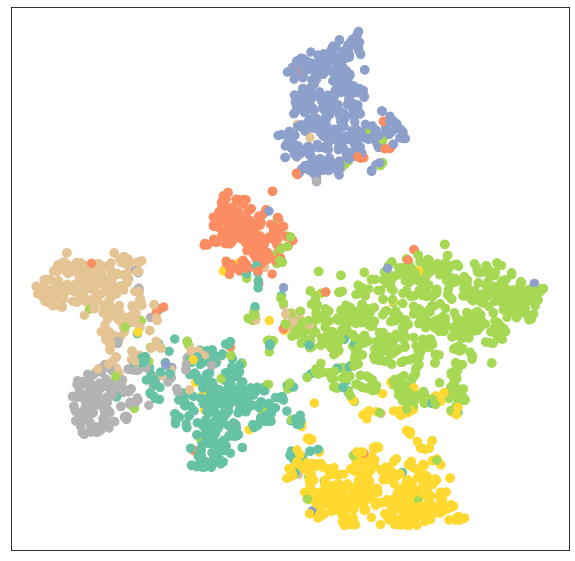

In [42]:
out = GCN_Model(dataset_GraphLime.x, dataset_GraphLime.edge_index)
visualize(out, color=data.y)

# **GraphLime**


In [56]:
from sklearn.linear_model import LassoLars
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import k_hop_subgraph

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [57]:
GraphLime_Explainer = GraphLIME(GCN_Model, hop=1, rho=0.1)

In [58]:
Coefficients_of_Test_Nodes = []

In [59]:
for i,index in enumerate(Test_Nodes_Index_List):
  #print(i,GraphLime_Explainer.explain_node(index, dataset_GraphLime.x, dataset_GraphLime.edge_index))
  Coefficients_of_Test_Nodes.append(GraphLime_Explainer.explain_node(index, dataset_GraphLime.x, dataset_GraphLime.edge_index))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:735: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:735: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=4.002e-01, previous alpha=4.002e-01, with an active set of 16 regressors.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:735: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_leas

In [60]:
print(len(Coefficients_of_Test_Nodes), len(Test_Nodes_Index_List))

817 817


In [61]:
Coefficients_of_Nodes_in_Class1 = []
Coefficients_of_Nodes_in_Class2 = []
Coefficients_of_Nodes_in_Class3 = []
Coefficients_of_Nodes_in_Class4 = []
Coefficients_of_Nodes_in_Class5 = []
Coefficients_of_Nodes_in_Class6 = []
Coefficients_of_Nodes_in_Class7 = []

In [62]:
for i in range(len(Test_Nodes_Index_List)):
  if dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 0:
    Coefficients_of_Nodes_in_Class1.append(Coefficients_of_Test_Nodes[i])

  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 1:
    Coefficients_of_Nodes_in_Class2.append(Coefficients_of_Test_Nodes[i])

  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 2:
    Coefficients_of_Nodes_in_Class3.append(Coefficients_of_Test_Nodes[i])

  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 3:
    Coefficients_of_Nodes_in_Class4.append(Coefficients_of_Test_Nodes[i])

  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 4:
    Coefficients_of_Nodes_in_Class5.append(Coefficients_of_Test_Nodes[i])

  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 5:
    Coefficients_of_Nodes_in_Class6.append(Coefficients_of_Test_Nodes[i])
    
  elif dataset_GraphLime.y[Test_Nodes_Index_List[i]] == 6:
    Coefficients_of_Nodes_in_Class7.append(Coefficients_of_Test_Nodes[i])

In [63]:
print(len(Coefficients_of_Nodes_in_Class1), len(Coefficients_of_Nodes_in_Class2), len(Coefficients_of_Nodes_in_Class3), len(Coefficients_of_Nodes_in_Class4), len(Coefficients_of_Nodes_in_Class5), len(Coefficients_of_Nodes_in_Class6), len(Coefficients_of_Nodes_in_Class7))

106 66 126 246 128 90 55


In [64]:
print(len(Coefficients_of_Nodes_in_Class1)+ len(Coefficients_of_Nodes_in_Class2) + len(Coefficients_of_Nodes_in_Class3) + len(Coefficients_of_Nodes_in_Class4) + len(Coefficients_of_Nodes_in_Class5) + len(Coefficients_of_Nodes_in_Class6) + len(Coefficients_of_Nodes_in_Class7))

817


In [65]:
Coefficients_of_Nodes_in_Class1_averaged = np.mean(Coefficients_of_Nodes_in_Class1, axis=0)
Coefficients_of_Nodes_in_Class2_averaged = np.mean(Coefficients_of_Nodes_in_Class2, axis=0)
Coefficients_of_Nodes_in_Class3_averaged = np.mean(Coefficients_of_Nodes_in_Class3, axis=0)
Coefficients_of_Nodes_in_Class4_averaged = np.mean(Coefficients_of_Nodes_in_Class4, axis=0)
Coefficients_of_Nodes_in_Class5_averaged = np.mean(Coefficients_of_Nodes_in_Class5, axis=0)
Coefficients_of_Nodes_in_Class6_averaged = np.mean(Coefficients_of_Nodes_in_Class6, axis=0)
Coefficients_of_Nodes_in_Class7_averaged = np.mean(Coefficients_of_Nodes_in_Class7, axis=0)

In [72]:
def GraphLime_Coefficients_Node_Features(average_coefficients_class):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "One," + " GNN Epoch Number = " + str(EPOCHS))
  
  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Two," + " GNN Epoch Number = " + str(EPOCHS))

  ax3 = plt.subplot2grid((7, 1), (2, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Three," + " GNN Epoch Number = " + str(EPOCHS))

  ax4 = plt.subplot2grid((7, 1), (3, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Four," + " GNN Epoch Number = " + str(EPOCHS))

  ax5 = plt.subplot2grid((7, 1), (4, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Five," + " GNN Epoch Number = " + str(EPOCHS))

  ax6 = plt.subplot2grid((7, 1), (5, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Six," + " GNN Epoch Number = " + str(EPOCHS))

  ax7 = plt.subplot2grid((7, 1), (6, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Coefficients')
  plt.title("Averaged Node Coefficients in Class : " + "Seven," + " GNN Epoch Number = " + str(EPOCHS))

  ax1.plot(average_coefficients_class[0], color='r')
  ax2.plot(average_coefficients_class[1], color='r')
  ax3.plot(average_coefficients_class[2], color='r')
  ax4.plot(average_coefficients_class[3], color='r')
  ax5.plot(average_coefficients_class[4], color='r')
  ax6.plot(average_coefficients_class[5], color='r')
  ax7.plot(average_coefficients_class[6], color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Averaged_Coefficients_in_each_Class" + ".png")
  plt.show()

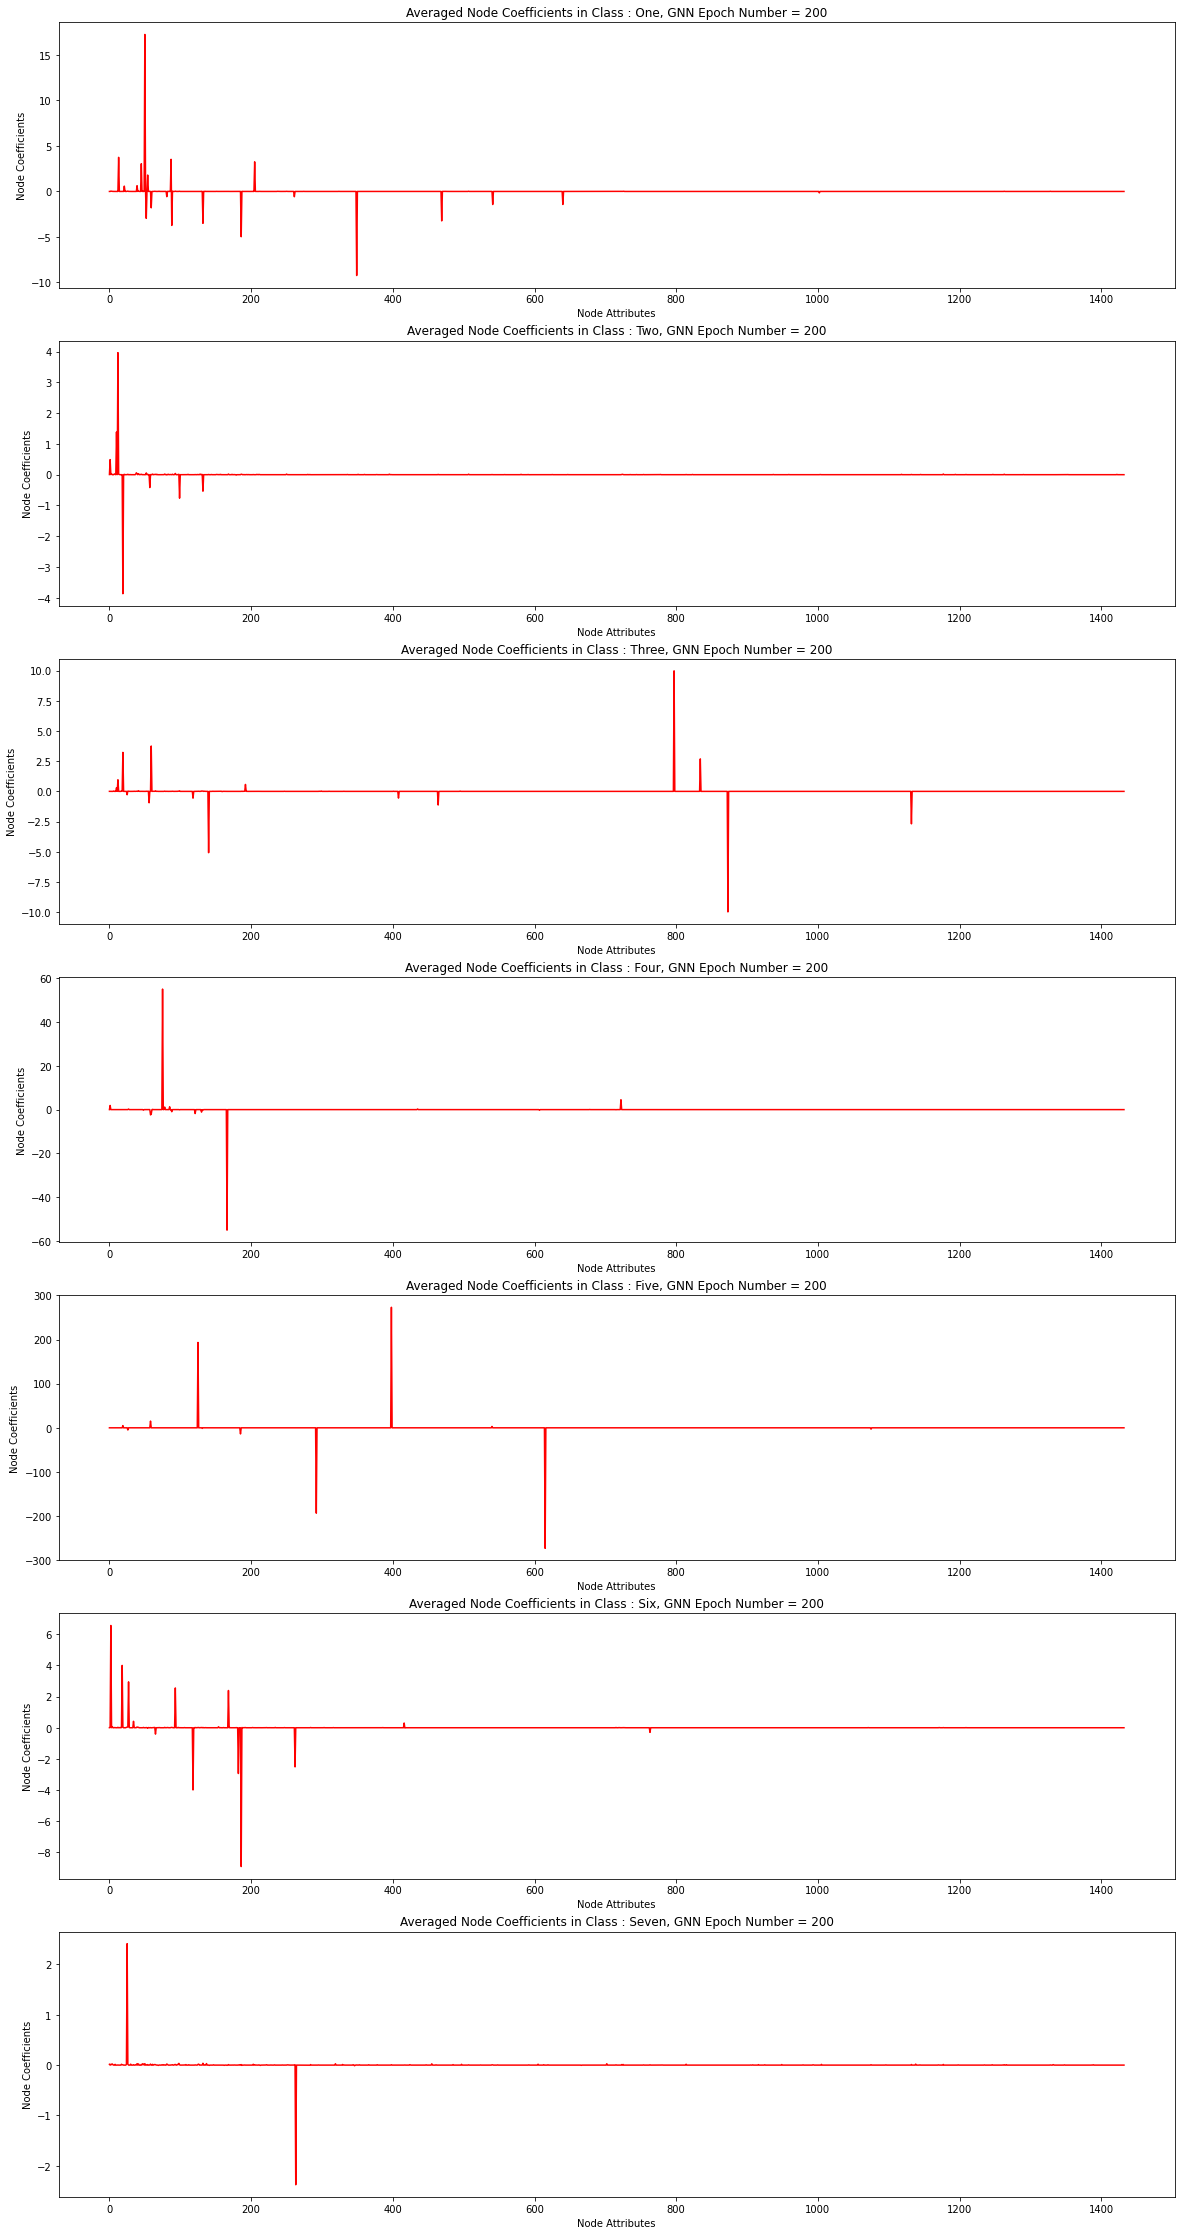

In [73]:
GraphLime_Coefficients_Node_Features([Coefficients_of_Nodes_in_Class1_averaged, Coefficients_of_Nodes_in_Class2_averaged, Coefficients_of_Nodes_in_Class3_averaged, Coefficients_of_Nodes_in_Class4_averaged, Coefficients_of_Nodes_in_Class5_averaged, Coefficients_of_Nodes_in_Class6_averaged, Coefficients_of_Nodes_in_Class7_averaged])